# Goal
Jacobo de la Cuesta-Zuluaga.

The aim of this notebook is to describe the abundance of members of *Methanomassiliicoccales* in different environments.

# Init

In [1]:
library(ggplot2)
library(tidyverse)
library(reshape2)
library(vegan)
library(cowplot)
library(caret)
library(forcats)
library(broom)
library(DESeq2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.3     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ dplyr   0.8.3
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  2.1.3     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-5

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘caret’

The following object is masked from ‘package:vegan’:

    tolerance

The following object is masked from ‘package:purrr’:

 

In [2]:
# R util functions
source("/ebio/abt3_projects/vadinCA11/data/V11/R_utils/utils.R")

In [3]:
# Load itol scripts
itol_dir = "/ebio/abt3_projects/vadinCA11/data/V11/itol"
itol_code = file.path(itol_dir, "itol.R") 
source(file = itol_code)

# Var 

In [4]:
distribution_dir = "/ebio/abt3_projects/vadinCA11/data/V11/Mmassilii_distribution/MGnify/"
metagenomes_dir = "/ebio/abt3_projects/databases_no-backup/MGnify/190900_dataset"

# KrakenUniq output dir
KrakenUniq_dir = file.path(distribution_dir, "krakenuniq")
KUniq_raw = file.path(KrakenUniq_dir, "report.tsv.gz") %>% 
    read_delim(delim = '\t')

# Metagenomes data
multiQC_raw = file.path(metagenomes_dir, "LLMGQC/reports/multiqc-final/multiqc_data/multiqc_fastqc.txt") %>% 
    read_delim(delim = '\t')

# Source of metagenomes
metadata_raw = file.path(metagenomes_dir, "MGnify_selected_metagenomes.tsv") %>%
    read_delim(delim = '\t')

# Mmassilii genomes information
Assemblies_table_raw = "/ebio/abt3_projects/vadinCA11/data/V11/genomes/included_table.txt" %>%
    read_delim(delim = '\t') %>%
    select(-1)

# Table of dereplicated genomes
dRep_table_raw = "/ebio/abt3_projects/vadinCA11/data/V11/drep/dereplication/data_tables/Cdb.csv" %>%
    read_csv()

plots_dir = "/ebio/abt3_projects/vadinCA11/data/V11/out_plots/"

Parsed with column specification:
cols(
  sample = col_character(),
  perc = col_double(),
  reads = col_double(),
  taxReads = col_double(),
  kmers = col_double(),
  dup = col_double(),
  cov = col_double(),
  taxID = col_double(),
  rank = col_character(),
  taxName = col_character(),
  taxName_full = col_character()
)
Parsed with column specification:
cols(
  .default = col_character(),
  `Total Sequences` = col_double(),
  `Sequences flagged as poor quality` = col_double(),
  `%GC` = col_double(),
  total_deduplicated_percentage = col_double(),
  avg_sequence_length = col_double()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_character(),
  host_tax_id = col_double(),
  raw_seq_count = col_double(),
  paired_reads = col_double(),
  n = col_double(),
  rand_sample = col_double(),
  category = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with c

In [5]:
# Clades of Methanomassilii
# Add Clade data to the metadata table and save
# Host Associated, Free Living and EXternal
HA_clade = c("GCA_002504405", "GCA_002506175", "GCA_002504495", "GCA_002506425", 
             "GCA_002503925", "GCA_002494805", "GCA_002498545", "GCA_002497475", 
             "GCA_002508595", "GCA_000800805", "GCA_002506905", "GCA_002496945", 
             "GCA_002495325", "GCA_002503545", "GCA_000300255", "V11_RL001", 
             "GCA_001481295", "GCA_900313075", "GCA_900314325", "GCA_002505245", 
             "GCA_002503785", "GCA_002506865", "GCA_002502545", "GCA_002509415", 
             "GCA_002498765", "GCA_002498785", "GCA_001421175", "GCA_002502965", 
             "GCA_002497155", "GCA_002509425", "GCA_002496785", "GCA_002505275", 
             "GCA_002506325", "GCA_002498605", "GCA_002509405", "GCA_002505345", 
             "GCA_002504645", "GCA_002502765", "GCA_002495665", "GCA_002506565", 
             "GCA_002508625", "GCA_002498425", "GCA_002498805", "GCA_002502925", 
             "GCA_002502465", "GCA_002498365", "GCA_002506995", "GCA_002494585", 
             "GCA_002509465", "GCA_002495495")

FL_clade = c("GCA_003153895", "GCA_003135935", "GCA_002506985", "GCA_002497075", 
             "GCA_000404225", "GCA_000308215", "GCA_002508545", "GCA_002494705", 
             "GCA_001421185", "GCA_002498285", "GCA_002495585", "GCA_002497995", 
             "GCA_002504525", "GCA_002496345", "GCA_002508585", "GCA_002508555", 
             "GCA_002502005", "GCA_002503495", "GCA_002505225", "GCA_002503645")

EX_clade = c("GCA_002496385", "GCA_002499085")

df_HA = data.frame(Assembly = HA_clade, Clade = rep("HA", length(HA_clade)))
df_FL = data.frame(Assembly = FL_clade, Clade = rep("FL", length(FL_clade)))
df_EX = data.frame(Assembly = EX_clade, Clade = rep("EX", length(EX_clade)))

df_Clade = bind_rows(df_HA, df_FL, df_EX) %>% 
    mutate(Clade = factor(Clade))

Assemblies_table = Assemblies_table_raw %>%
    select(-Assembly) %>%
    mutate(Organism = str_replace_all(Organism, " ", "_"), 
           Organism = str_remove_all(Organism, "\\."),
           Organism = str_replace_all(Organism, "-", "_"),
           Accession = str_remove(Accession, pattern = "\\.[:digit:]")) %>%
    rename("Accession" = "Assembly")

Assemblies_table = left_join(df_Clade, Assemblies_table) %>% 
    rename("Organism" = "Taxonomy") %>%
    arrange(Clade, Taxonomy)

Assemblies_table[Assemblies_table$Assembly == "V11_RL001", "Taxonomy"] = "Candidatus_Methanomethylophilus_alvus_RL001"

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Joining, by = "Assembly"


# Organize tables

## MultiQC of metagenomes

In [6]:
# Retain only R1
multiQC = multiQC_raw %>% 
    filter(Filename == "R1_final.fq.gz") %>%
    select(Sample, Sequences = "Total Sequences")
# Fix sample names
multiQC = multiQC %>% 
    pull(Sample) %>% 
    str_replace(fixed(" | fastqc_per_sample | R1_final"), "") %>%
    mutate(.data = multiQC, Sample = .)

sample_order = multiQC %>% 
    pull(Sample)

multiQC %>% dfhead

[1] 313   2


Sample,Sequences
<chr>,<dbl>
DRS034400,88844958
DRS034401,89593137
DRS034402,73790577


## KrakenUniq tables

## Environment information

In [7]:
# Prepare metadata table
# Filter metagenomes from wastewater and hospital biofilms

wastewater_ids = metadata_raw %>% 
    filter(biome_1 == "Engineered") %>% 
    pull(id) %>%
    as.character()

hospital_ids = metadata_raw %>%
    filter(biome_4 == "Drinking water") %>% 
    pull(id)

metadata = metadata_raw %>%
    filter(!(id %in% c(wastewater_ids, hospital_ids))) %>%
    select(id, starts_with("environment"), starts_with("biome")) %>% 
    mutate_all(.funs = c(factor))

In [8]:
# Keep data at assembly level, filter by kmer number and fix names
KUniq_relabund_raw = KUniq_raw %>%
    filter(rank == "assembly") %>%
    mutate(perc = case_when(kmers < 100 ~ 0, TRUE ~ as.numeric(perc))) %>%
    mutate(Accession = str_replace(taxName, "_[:digit:]$", "")) %>%
    mutate(Accession = str_replace_all(Accession, " ", "")) %>%
    select(sample, Accession, perc, reads) 

# Wide format
KUniq_relabund = KUniq_relabund_raw %>%
    select(sample, perc, Accession) %>%
    spread(sample, perc)

# Replace NAs for 0
KUniq_relabund[is.na(KUniq_relabund)] = 0

KUniq_relabund[is.na(KUniq_relabund)] = 0

# Remove wastewater samples, retain GIT and environmental samples
KUniq_relabund = KUniq_relabund %>% 
    left_join(df_Clade, by = c("Accession" = "Assembly")) %>%
    select(-one_of(c(wastewater_ids, hospital_ids)))

# KrakenUniq

In [9]:
# Mean abundance of each clade in each metagenome
Mean_clade_env = KUniq_relabund %>%
    select(-Accession) %>%
    group_by(Clade) %>%
    summarise_if(is.numeric, ~ mean(.))

In [10]:
# Obtain sum of all taxa in each clade in each sample
Sum_clade_env = KUniq_relabund %>%
    select(-Accession) %>%
    group_by(Clade) %>%
    summarise_if(is.numeric, list(sum)) %>% 
    t %>%
    as.data.frame %>%
    rownames_to_column()
    
colnames(Sum_clade_env) = c("Sample","EX","FL","HA")
Sum_clade_env = Sum_clade_env[-1,]
Sum_clade_env %>% dfhead

[1] 305   4


,Sample,EX,FL,HA
,<chr>,<fct>,<fct>,<fct>
2,ERS1030529,0.000000,0.008347,0.000000
3,ERS1030531,0.000000,0.003366,0.000000
4,ERS1030532,0.0000000,0.0048847,0.0000000


In [11]:
# Add source information
Sum_clade_source = left_join(Sum_clade_env, metadata, by = c("Sample" = "id")) %>%
    select(Sample, EX, FL, HA, Env = biome_4) %>%
    gather(Clade, Abundance, -c(Env, Sample)) %>%
    mutate(Abundance = as.numeric(Abundance)) %>%
    distinct()

Sum_clade_source %>% dfhead

Warning message:
“Column `Sample`/`id` joining character vector and factor, coercing into character vector”Warning message:
“attributes are not identical across measure variables;
they will be dropped”

[1] 915   4


Sample,Env,Clade,Abundance
<chr>,<fct>,<chr>,<dbl>
ERS1030529,Ice,EX,0
ERS1030531,Ice,EX,0
ERS1030532,Ice,EX,0


In [12]:
# Mean abundance of each clade on each environment
mean_clade_source = Sum_clade_source %>% 
    group_by(Env, Clade) %>%
    summarise(mean = mean(Abundance), sd = sd(Abundance)) %>%
    arrange(Env, -mean)

mean_clade_source 

Env,Clade,mean,sd
<fct>,<chr>,<dbl>,<dbl>
Coastal,FL,3.741121e-03,4.839059e-03
Coastal,HA,8.004893e-04,1.666619e-03
Coastal,EX,4.004750e-04,5.025856e-04
Desert,FL,1.839585e-02,1.161239e-03
Desert,HA,6.769795e-03,5.413107e-04
Desert,EX,1.507725e-03,1.502368e-04
Fecal,HA,2.109210e-02,3.913065e-02
Fecal,FL,8.499541e-03,1.098166e-02
Fecal,EX,3.201409e-04,5.485330e-04


Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 338 rows containing non-finite values (stat_summary).”Warning message:
“Removed 2 rows containing missing values (geom_pointrange).”

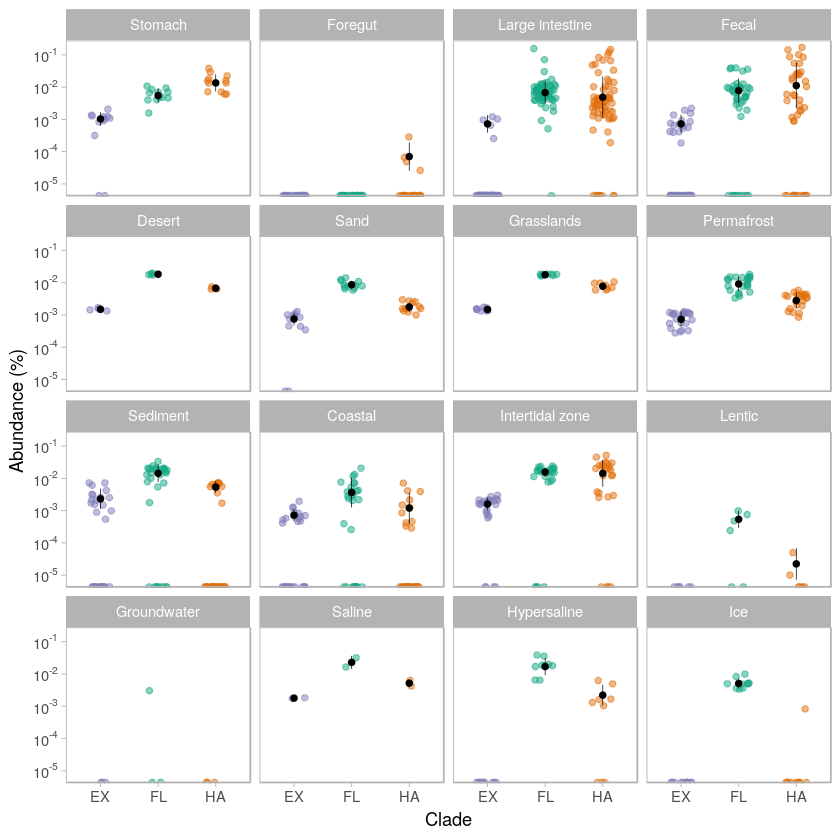

In [13]:
# Plot the abundance of each clade on each environment
options(repr.plot.width = 7, repr.plot.height = 7)

# Colors
clades_pallete = c("#7f7db9", "#15a783",  "#e16f0b")

# Order of facets
Envs_order = c("Stomach", "Foregut", "Large intestine", "Fecal",
               "Desert", "Sand", "Grasslands","Permafrost", "Sediment",
               "Coastal", "Intertidal zone", "Lentic", "Groundwater",
               "Saline", "Hypersaline", "Ice")

plt_distribution_df = Sum_clade_source %>% 
    mutate(Env = (str_remove_all(Env, "\\(anaerobic\\)")), 
           Env = fct_relevel(Env, Envs_order))

# Note change in clade name
# clade A -> "FL", clade B -> "HA" and clade C -> "EX"
plt_distribution = plt_distribution_df %>%
#      mutate(Clade = fct_recode(Clade, A = "FL", B = "HA", C = "EX"), 
#             Clade = fct_relevel(Clade, c("A", "B", "C"))) %>%
    ggplot(., aes(x = Clade, y = Abundance, color  = Clade)) +
    geom_jitter(alpha = 0.5, position = position_jitter(width = 0.2, height = 0)) +
    facet_wrap(~Env, nrow = 4) +
    scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x), 
                labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    labs(y = "Abundance (%)") +
    scale_color_manual(values = clades_pallete) +
    theme_light() +
    theme(legend.position="none", 
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank()) +
    stat_summary(fun.y = mean, 
                 fun.ymin = function(x) mean(x) - sd(x), 
                 fun.ymax = function(x) mean(x) + sd(x), 
                 geom = "pointrange", colour = "black", size = 0.2)
plot(plt_distribution)

In [14]:
plot_file = file.path(plots_dir, "Mmassilii_distribution.png")
save_plot(filename = plot_file, plot = plt_distribution,
          base_height = 7, base_width = 7, dpi = 300)

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 338 rows containing non-finite values (stat_summary).”Warning message:
“Removed 2 rows containing missing values (geom_pointrange).”

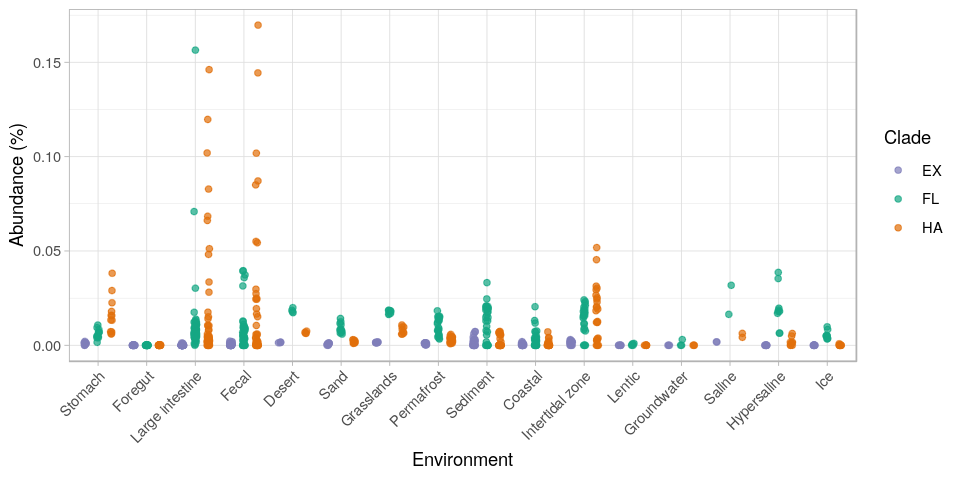

In [15]:
options(repr.plot.width = 8, repr.plot.height = 4)

plt = ggplot(plt_distribution_df, aes(x = Env, y = Abundance, color = Clade)) +
    geom_jitter(alpha = 0.7, position = position_jitterdodge(dodge.width = 0.8, jitter.width = 0.05)) +
    theme_light() +
    scale_color_manual(values = clades_pallete) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(x = "Environment", y = "Abundance (%)")
    
plot(plt)

## Summaries

In [16]:
# Add source information
Sum_clade_b = left_join(Sum_clade_env, metadata, by = c("Sample" = "id")) %>%
    select(Sample, EX, FL, HA, Env = biome_4) %>%
    gather(Clade, Abundance, -c(Env, Sample)) %>%
    mutate(Abundance = as.numeric(Abundance)) %>%
    distinct()

Sum_clade_b %>% dfhead

# Mean abundance of each clade on each environment
mean_clade_b = Sum_clade_b %>% 
    group_by(Env, Clade) %>%
    summarise(mean = mean(Abundance), sd = sd(Abundance)) %>%
    arrange(Env, -mean)

mean_clade_b %>% 
    mutate_if(is.numeric, round, 4) %>%
    arrange(Clade)

Warning message:
“Column `Sample`/`id` joining character vector and factor, coercing into character vector”Warning message:
“attributes are not identical across measure variables;
they will be dropped”

[1] 915   4


Sample,Env,Clade,Abundance
<chr>,<fct>,<chr>,<dbl>
ERS1030529,Ice,EX,0
ERS1030531,Ice,EX,0
ERS1030532,Ice,EX,0


`mutate_if()` ignored the following grouping variables:
Column `Env`


Env,Clade,mean,sd
<fct>,<chr>,<dbl>,<dbl>
Coastal,EX,0.0004,0.0005
Desert,EX,0.0015,0.0002
Fecal,EX,0.0003,0.0005
Foregut,EX,0.0000,0.0000
Grasslands,EX,0.0015,0.0002
Groundwater,EX,0.0000,0.0000
Hypersaline,EX,0.0000,0.0000
Ice,EX,0.0000,0.0000
Intertidal zone,EX,0.0015,0.0009


### Mean of each clade in gut/environmental biomes

In [17]:

# Categorize metagenome samples as Gut or nonGut (i.e. environmental)
gut_envs = c("Fecal", "Foregut", "Large intestine","Stomach")


Sum_clade_source %>%
    mutate(Env_binary = ifelse(Env %in% gut_envs, "Gut", "nonGut")) %>%
    group_by(Clade, Env_binary) %>%
    summarise(mean = mean(Abundance, na.rm = T), 
              sd = sd(Abundance, na.rm = T)) %>%
    mutate_if(is.numeric, function(x) round(x, 4))

`mutate_if()` ignored the following grouping variables:
Column `Clade`


Clade,Env_binary,mean,sd
<chr>,<chr>,<dbl>,<dbl>
EX,Gut,0.0002,0.0005
EX,nonGut,0.0009,0.0012
FL,Gut,0.0078,0.0154
FL,nonGut,0.0104,0.0083
HA,Gut,0.0143,0.0301
HA,nonGut,0.0045,0.0081


In [18]:


metadata_DESeq = metadata %>% 
    mutate(Env_binary = ifelse(biome_4 %in% gut_envs, "Gut", "nonGut")) %>%
    select(id, Env_binary) %>%
    filter(id != "SRS429585") %>%
    distinct %>% 
    column_to_rownames("id")

## Abundance of each taxon in each environment

In [19]:
# Function to obtain mean abundance of taxa in each environment
taxa_mean = function(abundance_table, environment, metadata, biome_var){
  
    Env_metagenomes = metadata %>% 
        filter({{ biome_var }} == environment) %>%
        pull(id) %>%
        as.vector()

    Env_mean = abundance_table %>% 
        select(one_of(Env_metagenomes)) %>%
        rowMeans

    Env_mean    
}

In [20]:
# Range of individual genomes across all samples
KUniq_relabund %>% 
    select(-Accession, -Clade) %>%
    map_dbl(function(x) max(x, na.rm = TRUE)) %>%
    min()

KUniq_relabund %>% 
    select(-Accession, -Clade) %>%
    map_dbl(function(x) max(x, na.rm = TRUE)) %>%
    max() 

[1] 0

[1] 0.1453

In [21]:
# Filter metagenomes metadata table to retain only samples with abundance data
present_samples = KUniq_relabund %>%
    select(-Accession, -Clade) %>%
    colnames()

filt_metadata = metadata %>%
    filter(id %in% present_samples)

Environments = metadata %>% 
    pull(biome_1) %>% 
    unique()

Tax_env_mean_1 = map(Environments, function(x) taxa_mean(KUniq_relabund, x, filt_metadata, biome_1)) %>%
    set_names(., Environments) %>%
    as.data.frame()     
                   
Tax_env_mean_1 = bind_cols(Taxon = KUniq_relabund$Accession, Tax_env_mean_1) %>%
    gather(Environment, Abundance, -c(Taxon))
                     
Tax_env_mean_1 %>% 
    group_by(Environment) %>% 
    summarise(min = min(Abundance), max = max(Abundance))

Environment,min,max
<chr>,<dbl>,<dbl>
Environmental,3.397125e-06,0.002237551
Host.associated,1.769655e-06,0.008387321


In [22]:
# Filter metagenomes metadata table to retain only samples with abundance data
present_samples = KUniq_relabund %>%
    select(-Accession, -Clade) %>%
    colnames()

filt_metadata = metadata %>%
    filter(id %in% present_samples)


Environments = metadata %>% 
    pull(biome_4) %>% 
    unique()

Tax_env_mean = map(Environments, function(x) taxa_mean(KUniq_relabund, x, filt_metadata, biome_4)) %>%
    set_names(., Environments) %>%
    as.data.frame()     
                   
Tax_env_mean = bind_cols(Taxon = KUniq_relabund$Accession, Tax_env_mean) %>%
    gather(Environment, Abundance, -c(Taxon))
Tax_env_mean %>% dfhead

[1] 464   3


Taxon,Environment,Abundance
<chr>,<chr>,<dbl>
GCA_000308215,Large.intestine,1.117073e-03
GCA_000404225,Large.intestine,7.813636e-06
GCA_000800805,Large.intestine,6.025758e-05


In [23]:
# Long format and add envinronment and clade data
# Reorder levels of Taxon for plot

metagenomes_biome4 = metadata %>%
    select(id, biome_4) %>%
    filter(!duplicated(.))

Tax_per_samp = KUniq_relabund %>%
    select(-Clade) %>%
    gather(Sample, Abundance, -Accession) %>%
    left_join(., metagenomes_biome4, by = c("Sample" = "id")) %>%
    left_join(., Assemblies_table, by = c("Accession" = "Assembly"))

Tax_per_samp %>% dfhead

Warning message:
“Column `Sample`/`id` joining character vector and factor, coercing into character vector”

[1] 8845    6


Accession,Sample,Abundance,biome_4,Clade,Taxonomy
<chr>,<chr>,<dbl>,<fct>,<fct>,<chr>
GCA_000308215,ERS1030529,0.001279,Ice,FL,Methanomassiliicoccus_luminyensis_B10
GCA_000404225,ERS1030529,0.000000,Ice,FL,Candidatus_Methanomassiliicoccus_intestinalis_Issoire_Mx1
GCA_000800805,ERS1030529,0.000000,Ice,HA,Candidatus_Methanoplasma_termitum


In [24]:
plt_fun = function(environment, abundance_table){
    clades_pallete = c("#7f7db9", "#15a783", "#e16f0b")
    
    plt = abundance_table %>% 
    filter(biome_4 == environment) %>%
    #arrange(Clade) %>%
    ggplot(., aes(x = Taxonomy, y = Abundance, color = Clade)) +
        geom_jitter(alpha = 0.7, position = position_jitter(width = 0.2, height = 0))  + 
        scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x), 
                labels = scales::trans_format("log10", scales::math_format(10^.x))) +
        theme_light() +
        scale_color_manual(values = clades_pallete) +
        theme(panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.text.x = element_text(angle = 45, hjust = 1),
              legend.position = "none") +
        labs(x = "Taxon", y = "Abundance (%)", title = environment) +
        stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), 
                     geom="pointrange", color="black", size = 0.2) +
        coord_flip()
}

# envs_vector = metadata %>%
#     pull(biome_4) %>%
#     levels

Tax_per_samp = Tax_per_samp %>% 
    mutate(Taxonomy = str_remove(Taxonomy, "uncultured")) %>%
    arrange(Clade, Taxonomy) %>% 
    mutate(Taxonomy = factor(Taxonomy),
           Taxonomy = str_replace_all(Taxonomy, "_", " "),
           Taxonomy = fct_inorder(Taxonomy))

plots_environment = map(Envs_order, function(x) plt_fun(x, Tax_per_samp))

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 77 rows containing non-finite values (stat_summary).”Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 663 rows containing non-finite values (stat_summary).”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 1327 rows containing non-finite values (stat_summary).”Warning message:
“Removed 2 rows containing missing values (geom_pointrange).”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation intr

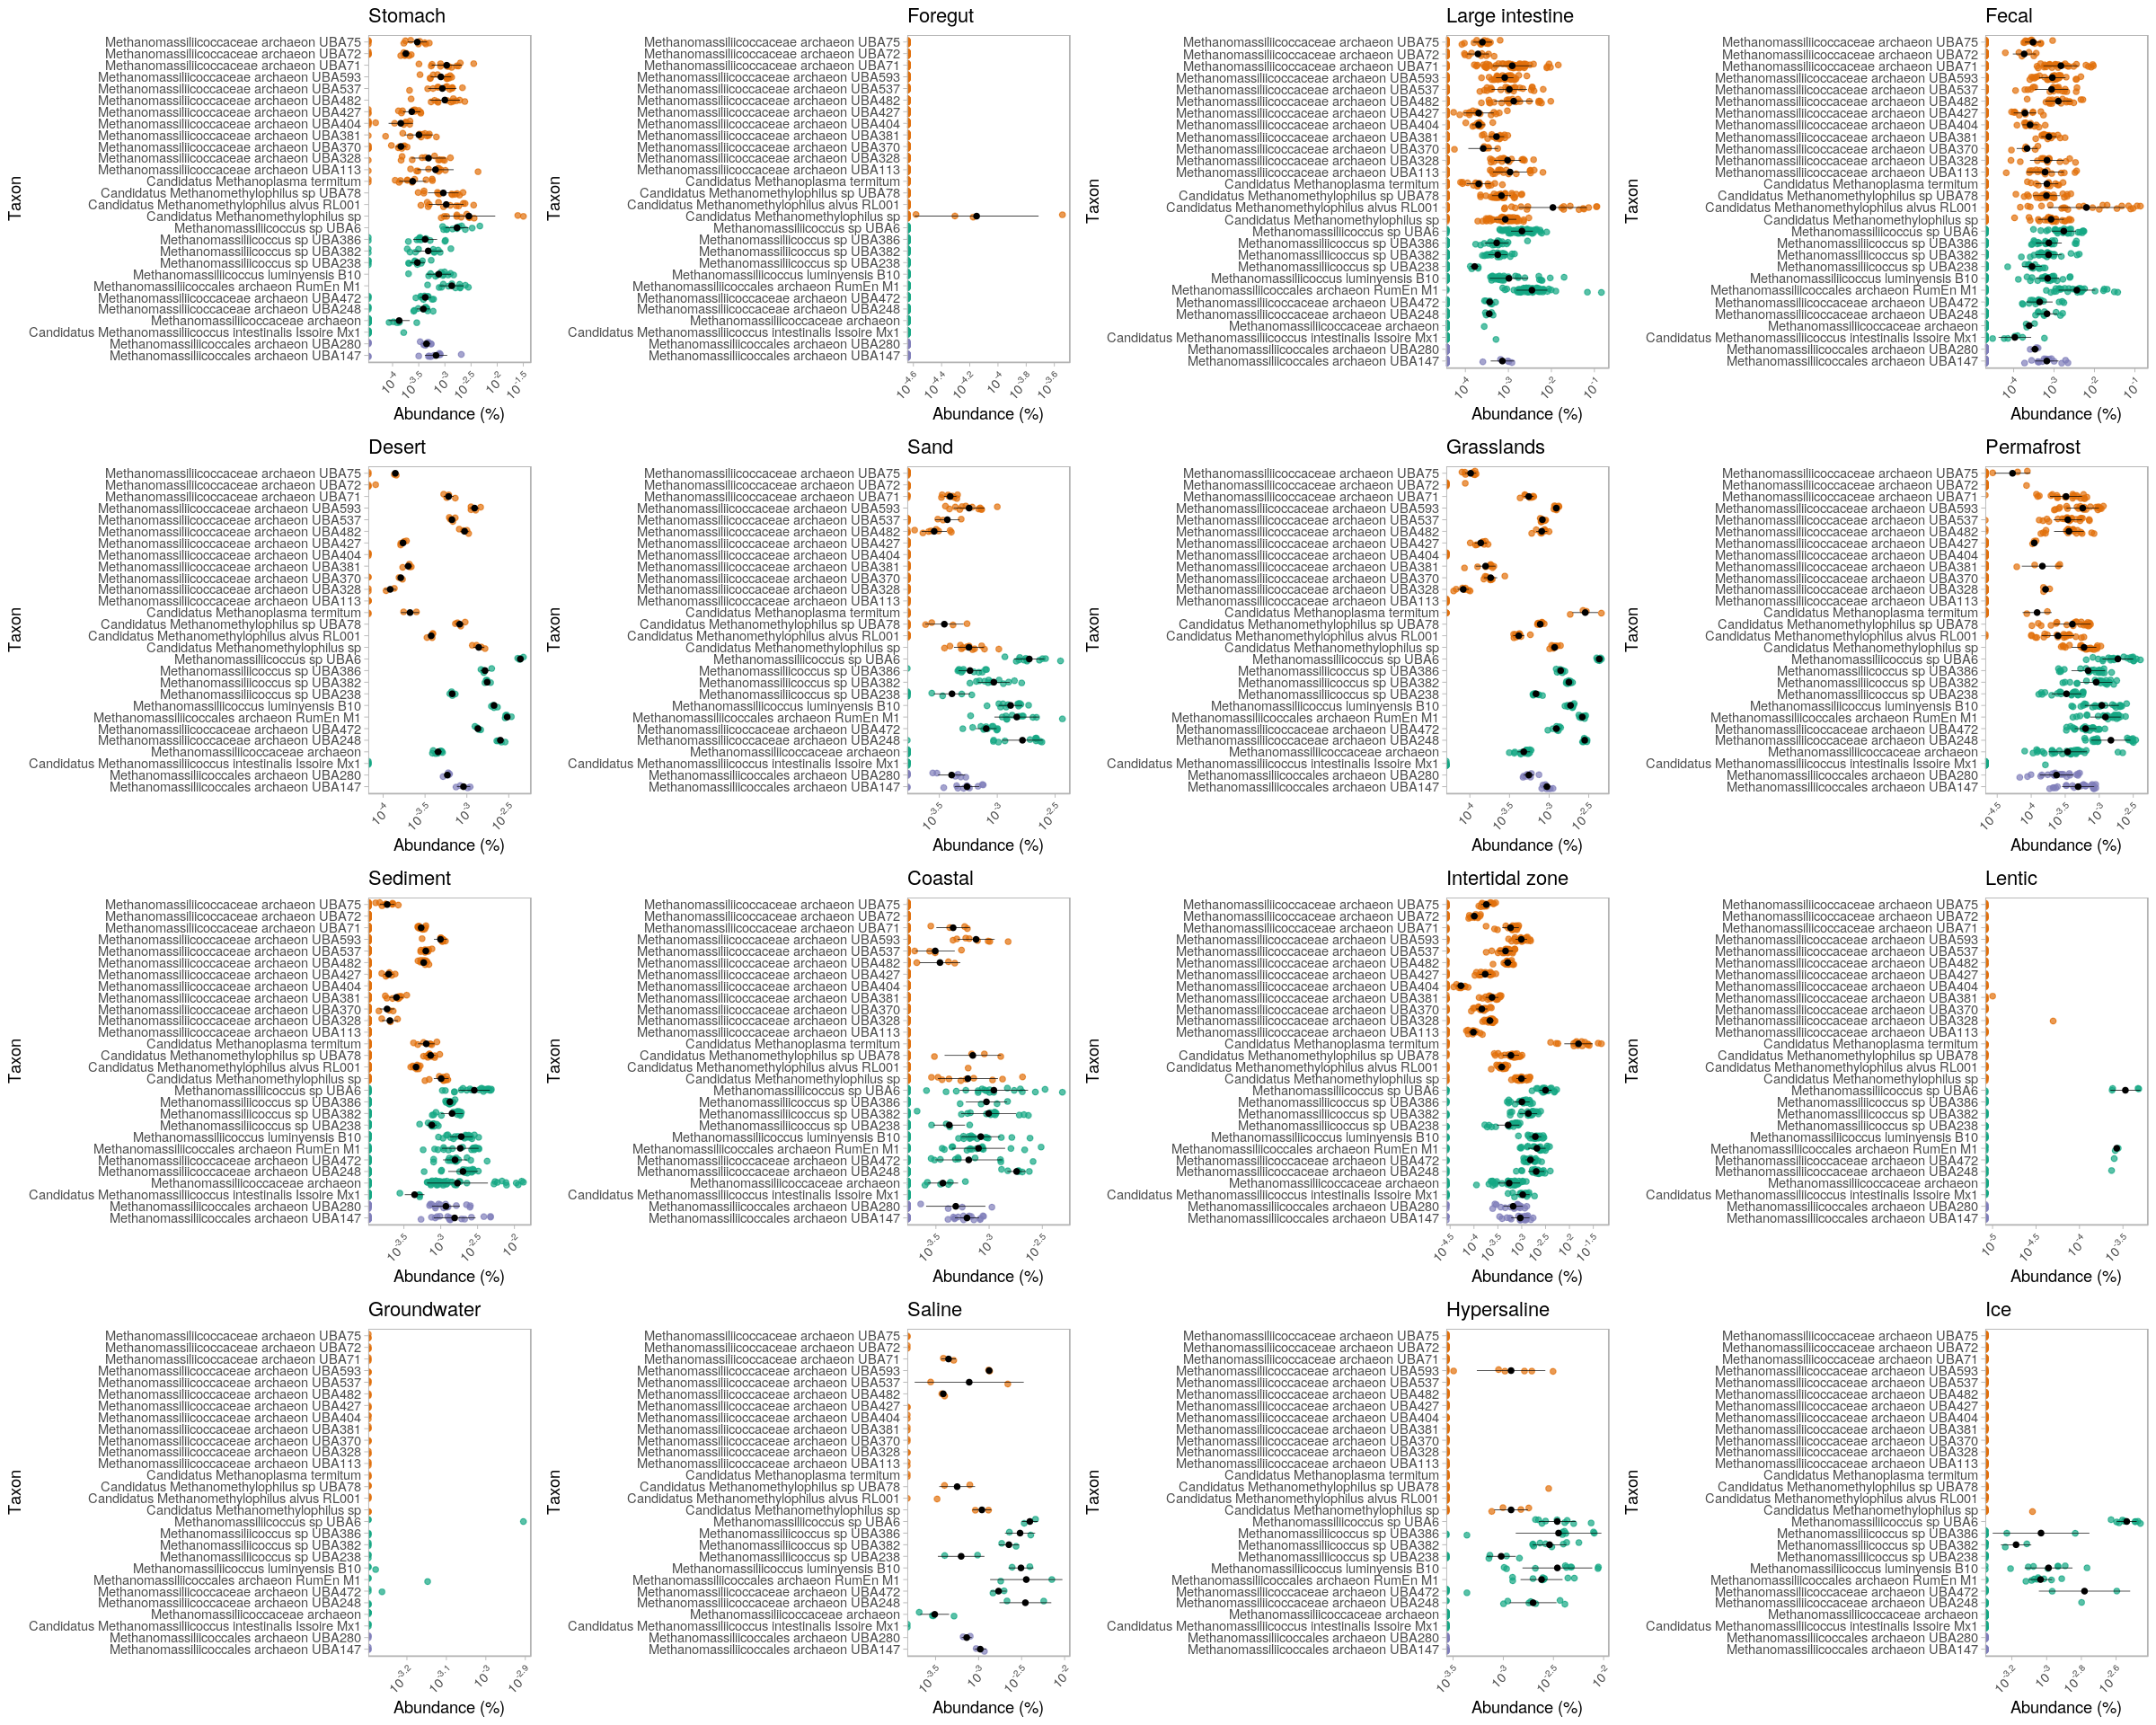

In [25]:
options(repr.plot.width = 20, repr.plot.height =  length(plots_environment))
Mmassilii_genomes_distribution = plot_grid(plotlist = plots_environment, ncol = 4)
Mmassilii_genomes_distribution

plot_file = file.path(plots_dir, "Mmassilii_genomes_distribution.png")
save_plot(filename = plot_file, plot = Mmassilii_genomes_distribution,
          base_height = 20, base_width = 1.2*length(plots_environment), dpi = 300)

## Tables

In [26]:
# Number of samples per environment
Sum_clade_source %>% 
    group_by(Env, Clade) %>% 
    filter(Clade == "HA") %>%
    summarise(n = n()) 

Env,Clade,n
<fct>,<chr>,<int>
Coastal,HA,28
Desert,HA,4
Fecal,HA,44
Foregut,HA,23
Grasslands,HA,8
Groundwater,HA,3
Hypersaline,HA,9
Ice,HA,10
Intertidal zone,HA,25


In [27]:
# Mean and SD of clade by environment
Mean_clade_source = Sum_clade_source %>% 
    group_by(Env, Clade) %>% 
    summarise(mean_abund = round(mean(Abundance), 4), sd = round(sd(Abundance), 4))  %>%
    arrange(Clade, -mean_abund)

Mean_clade_source %>% dfhead

[1] 48  4


Env,Clade,mean_abund,sd
<fct>,<chr>,<dbl>,<dbl>
Saline,EX,0.0018,0.0001
Sediment,EX,0.0016,0.0021
Desert,EX,0.0015,0.0002


# DESeq2

In [28]:
# Create table of sequence counts for Use in DESeq
# Observations with < 100 unique kmers are considered 0
KUniq_DESeq = KUniq_raw %>%
    filter(rank == "assembly") %>%
    mutate(reads = case_when(kmers < 100 ~ 0, TRUE ~ as.numeric(reads))) %>%
    mutate(Accession = str_replace(taxName, "_[:digit:]$", "")) %>%
    mutate(Accession = str_replace_all(Accession, " ", "")) %>%
    select(sample, Accession, reads) 

# Remove metagenome samples from anthropogenic samples
KUniq_DESeq = KUniq_DESeq %>% 
    filter(sample %in% metadata$id) %>%
    spread(sample, reads) %>%
    column_to_rownames("Accession")

# Add 1 to each count so DESeq can run
KUniq_DESeq[is.na(KUniq_DESeq)] = 0
KUniq_DESeq = KUniq_DESeq + 1

In [29]:
# Categorize metagenome samples as Gut or nonGut (i.e. environmental)
gut_envs = c("Fecal", "Foregut", "Large intestine","Stomach")

metadata_DESeq = metadata %>% 
    mutate(Env_binary = ifelse(biome_4 %in% gut_envs, "Gut", "nonGut")) %>%
    select(id, Env_binary) %>%
    filter(id != "SRS429585") %>%
    distinct %>% 
    column_to_rownames("id")

KUniq_DESeq = KUniq_DESeq[, rownames(metadata_DESeq)]

KUniq_DESeq %>% dfhead
metadata_DESeq %>% dfhead

[1]  29 305


,ERS723591,ERS723612,ERS723614,ERS723595,ERS723671,ERS723593,ERS723663,ERS723676,ERS723606,ERS723624,⋯,ERS970416,ERS2085267,ERS2085081,ERS2085419,ERS970200,ERS2085357,ERS970227,ERS970396,ERS970222,ERS970335
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GCA_000308215,1,1,1,1,1,1,1346,2123,1,1,⋯,66,146,276,77,751,166,82,206,543,264
GCA_000404225,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
GCA_000800805,1,1,1,1,1,1,1,1,1,1,⋯,23,355,420,1,36,65,80,1,26,64


[1] 305   1


,Env_binary
,<chr>
ERS723591,Gut
ERS723612,Gut
ERS723614,Gut


In [30]:
# Run DESeq to determine taxa enriched in gut compared to nonGut environments
dds = DESeqDataSetFromMatrix(countData = KUniq_DESeq,
                              colData = metadata_DESeq,
                              design = ~ Env_binary)

dds = DESeq(dds, fitType = "mean")
dds_results = results(dds)

converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 10 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [31]:
# Results to data frame
dds_table = dds_results %>% 
    as.data.frame %>%
    rownames_to_column("Accession")

# Join DESeq results with assembly data
dds_table = left_join(dds_table, Assemblies_table, by = c("Accession" = "Assembly")) %>%
    arrange(log2FoldChange) %>%
    mutate(significant = if_else(padj <= 0.1, TRUE, FALSE))

In [32]:
dRep_table = dRep_table_raw %>%
    select(Accession = genome, Cluster = secondary_cluster) %>%
    mutate(Accession = str_remove(Accession, "\\..*"))

In [33]:
# Join GE ratio of representatives with dereplication table
# Replace NAs for the mean abund and GE ratio of representative of cluster

GE_ratio_DESeq = full_join(dRep_table, dds_table, by = "Accession") %>%
    mutate(Rep_genome = ifelse(is.na(log2FoldChange), F, T)) %>%
    group_by(Cluster) %>%
    do(arrange(., -Rep_genome) %>% 
       mutate(log2FoldChange = .$log2FoldChange[1], 
              padj = .$padj[1], 
              significant = .$significant[1])) %>%
    ungroup() %>%
    select(Accession, log2FoldChange, padj, significant) 

# Reorder factors for plotting
GE_ratio_DESeq = full_join(GE_ratio_DESeq, Assemblies_table, by = c("Accession" = "Assembly")) %>%
    arrange(log2FoldChange) %>%
    mutate(Accession = fct_inorder(Accession), Taxonomy = fct_inorder(Taxonomy)) 

In [34]:
# Taxa with log2 fold change opposite to the expected given their clade
GE_ratio_DESeq %>% filter(Clade == "FL", log2FoldChange < 0)
GE_ratio_DESeq %>% filter(Clade == "HA", log2FoldChange > 0)

Accession,log2FoldChange,padj,significant,Clade,Taxonomy
<fct>,<dbl>,<dbl>,<lgl>,<fct>,<fct>
GCA_001421185,-3.6098934,7.745669e-40,TRUE,FL,Methanomassiliicoccales_archaeon_RumEn_M1
GCA_002508545,-0.9977002,8.689222e-05,TRUE,FL,Methanomassiliicoccus_sp_UBA6
GCA_000404225,-0.5015206,8.516560e-02,TRUE,FL,Candidatus_Methanomassiliicoccus_intestinalis_Issoire_Mx1
GCA_000308215,-0.1212717,6.655059e-01,FALSE,FL,Methanomassiliicoccus_luminyensis_B10


Accession,log2FoldChange,padj,significant,Clade,Taxonomy
<fct>,<dbl>,<dbl>,<lgl>,<fct>,<fct>
GCA_000800805,1.326174,8.537341e-07,TRUE,HA,Candidatus_Methanoplasma_termitum


## Export tables and ITOL files

In [35]:
# Save ITOL bar chart
GE_ratio_DESeq %>%
    column_to_rownames("Accession") %>%
    select(log2FoldChange) %>%
    itol_simplebar(df = ., dataset_label = "Fold_Change", 
                    out_file = "DESeq_simplebar.txt", out_dir =  itol_dir)

File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/DESeq_simplebar.txt 


In [36]:
# Save ITOL significance
GE_ratio_DESeq %>%
    mutate(significant = if_else(significant == TRUE, 1, 0)) %>%
    column_to_rownames("Accession") %>%
    select(significant) %>%
    itol_externalshape(df = ., dataset_label = "Enrichment_Significance", 
                    out_file = "DESeq_externalshape.txt", out_dir =  itol_dir)

File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/DESeq_externalshape.txt 


In [37]:
# Environment enrichment in a single color strip summary
GE_ratio_DESeq %>%
    mutate(simple_enrich = case_when((log2FoldChange > 0 & significant == T) ~ "Environmental",
                                     (log2FoldChange < 0 & significant == T) ~ "Gut", 
                                     TRUE ~ "Non-significant")) %>%
    column_to_rownames("Accession") %>%
    select(simple_enrich) %>%
    itol_colorstrip(df = ., dataset_label = "Enrichment_summary", 
                    out_file = "simple_enrich_colorstrip.txt", out_dir =  itol_dir)

File written: /ebio/abt3_projects/vadinCA11/data/V11/itol/simple_enrich_colorstrip.txt 


In [38]:
# Export DESeq simple enrichment table
Simple_enrich_df = GE_ratio_DESeq %>%
    mutate(simple_enrich = case_when((log2FoldChange > 0 & significant == T) ~ "Environmental",
                                     (log2FoldChange < 0 & significant == T) ~ "Gut", 
                                   TRUE ~ "Non-significant")) 

write_tsv(Simple_enrich_df, "/ebio/abt3_projects/vadinCA11/data/V11/Mmassilii_distribution/Enrichment/Simple_Enrich.tsv")

## Unsupervised clustering of Log fold change

In [39]:
library(ape)
# Load phylogenomic tree
#phylo_tree_file = file.path("/ebio/abt3_projects/vadinCA11/data/V11/anvio_output/phylogenomic_tree.txt")
phylo_tree_file = file.path("/ebio/abt3_projects/vadinCA11/data/V11/phylophlan/trees/RAxML_bipartitions.methanomassilii.tre")
phylogenomic_tree_raw = read.tree(phylo_tree_file)
phylogenomic_tree_raw$node.label = c() # solves the "Labels are not unique" message


# Root tree and remove root for downstream analyses
outgroup_clades = c("GCA_900090055", "GCA_000195915", "GCA_900176435", "GCA_000152265", "GCA_001402945")
phylogenomic_tree_raw = phylogenomic_tree_raw %>% root(., outgroup = outgroup_clades)
phylogenomic_tree = phylogenomic_tree_raw %>% drop.tip(., outgroup_clades)

phylogenomic_tree = phytools::force.ultrametric(phylogenomic_tree)

In [40]:
# Create dendrogram using log2fold enrichment values
log_dendro = GE_ratio_DESeq %>%
    select(Accession, fold = log2FoldChange) %>%
    column_to_rownames("Accession") %>%
    dist() %>%
    hclust(method = "average") 

In [42]:
# Create two groups using the enrichment dendrogram
enrich_clusters = cutree(log_dendro, k = 2)
enrich_clusters = tst %>% 
    as.factor() %>%
    as.data.frame() %>%
    rownames_to_column("col")
colnames(enrich_clusters) = c("Accession", "Clust_group")

enrich_clusters = left_join(GE_ratio_DESeq, tst_2) %>%
    select(Accession, Taxonomy, Clade, Clust_group)

enrich_clusters %>% dfhead

ERROR: Error in tbl_vars_dispatch(x): object 'tst_2' not found


In [ ]:
options(repr.plot.width = 12, repr.plot.height = 12)
log_phylo_dendlist = dendextend::dendlist(as.dendrogram(log_dendro), as.dendrogram(phylogenomic_tree)) %>%
    dendextend::untangle(method = "step1side") 


log_phylo_dendlist%>%
    dendextend::tanglegram(highlight_distinct_edges = FALSE,
                           common_subtrees_color_lines = FALSE, 
                           margin_inner = 8)

In [ ]:
# Calculate correlation between enrichment dendrogram and phylogenomic tree
observed_correlation = dendextend::cor_cophenetic(log_phylo_dendlist)
observed_correlation

In [ ]:
# Compute significance of correlation between dendrogram and phylogenomic tree by bootstraping

# Empty P value vector
permuted_cor_values = c()

# Permute dendrogram tips
for(i in 1:1000){
    # Randomly permute tips
    perm_denro = log_dendro
    perm_denro$labels = sample(perm_denro$labels)
    
    # Create dendro list
    perm_dendlist = dendextend::dendlist(as.dendrogram(perm_denro), 
                                         as.dendrogram(phylogenomic_tree)) 
    
    # Calculate correlation
    perm_cor = dendextend::cor_cophenetic(perm_dendlist)
    
    # Append to vector
    permuted_cor_values = c(permuted_cor_values, perm_cor)
}

In [ ]:
# Calculate number of permuted values greater than observed correlation 
sum(permuted_cor_values > observed_correlation)/length(permuted_cor_values)

# Mmassilii in gut environments

In [44]:
metadata_animal = metadata_raw %>% 
    filter(!duplicated(.)) %>%
    select(id, starts_with("environment"), starts_with("biome"), host_tax_id) %>%
    filter(biome_1 == "Host-associated") %>% 
    mutate(host_species = case_when(host_tax_id == 8022 ~ "Rainbow trout", 
                                    host_tax_id == 8847 ~ "Goose", 
                                    host_tax_id == 9685 ~ "Cat",
                                    host_tax_id == 9823 ~ "Pig",
                                    host_tax_id == 9852 ~ "Eurasian elk",
                                    host_tax_id == 9913 ~ "Cattle",
                                    host_tax_id == 9940 ~ "Sheep",
                                    host_tax_id == 10090 ~ "Mouse",
                                    host_tax_id == 42408 ~ "White-throated woodrat")) %>%
    mutate(host_species = case_when(environment_biome == "poultry" ~ "Poultry", 
                                    TRUE ~ host_species)) %>%
    filter(!duplicated(.))

metadata_animal %>% dfhead

[1] 146  12


id,environment_biome,environment_feature,environment_material,biome_0,biome_1,biome_2,biome_3,biome_4,biome_5,host_tax_id,host_species
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
ERS723591,Faeces,Faeces,Faeces,root,Host-associated,Mammals,Digestive system,Large intestine,Fecal,9685,Cat
ERS723612,Faeces,Faeces,Faeces,root,Host-associated,Mammals,Digestive system,Large intestine,Fecal,9685,Cat
ERS723614,Faeces,Faeces,Faeces,root,Host-associated,Mammals,Digestive system,Large intestine,Fecal,9685,Cat


In [ ]:
gut_ids = metadata_animal %>% 
    pull(id) 

Mmassilii_gut = Tax_per_samp %>%
    #filter(Accession %in% c("V11_RL001", "GCA_000308215", "GCA_000404225")) %>%
    filter(Sample %in% gut_ids)

Mmassilii_gut = left_join(Mmassilii_gut, metadata_animal, by = c("Sample" = "id", "biome_4"))

Mmassilii_gut %>% dfhead

In [ ]:
plt_fun_gut = function(environment, abundance_table){
    clades_pallete = c("#7f7db9", "#15a783", "#e16f0b")
    
    plt = abundance_table %>% 
    filter(host_species == environment) %>%
    #arrange(Clade) %>%
    ggplot(., aes(x = Taxonomy, y = Abundance, color = Clade)) +
        geom_jitter(alpha = 0.7, position = position_jitter(width = 0.2, height = 0))  + 
        scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x), 
                labels = scales::trans_format("log10", scales::math_format(10^.x))) +
        theme_light() +
        scale_color_manual(values = clades_pallete) +
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank()) +
        labs(x = "Taxon", y = "Abundance (%)", title = environment) +
        stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), 
                     geom="pointrange", color="black", size = 0.2) +
        coord_flip()
}

envs_vector = Mmassilii_gut %>%
    pull(host_species) %>%
    unique


Mmassilii_gut = Mmassilii_gut %>% 
    mutate(Taxonomy = str_remove(Taxonomy, "uncultured")) %>%
    arrange(Clade, Taxonomy) %>% 
    mutate(Taxonomy = factor(Taxonomy),
           Taxonomy = str_replace_all(Taxonomy, "_", " "),
           Taxonomy = fct_inorder(Taxonomy))


plots_gut = map(envs_vector, function(x) plt_fun_gut(x, Mmassilii_gut))

In [ ]:
options(repr.plot.width = 12, repr.plot.height =  1.5*length(plots_environment))
suppressWarnings(plot_grid(plotlist = plots_gut, ncol = 2, align = "v"))

In [ ]:
gut_mean_ranks = Mmassilii_gut %>%
    group_by(Accession, host_species) %>%
    summarise(mean_abund = round(mean(Abundance), 4)) %>% 
    arrange(host_species, -mean_abund) %>% 
    ungroup() %>%
    group_by(host_species) %>%
    mutate(rank = row_number()) %>%
    ungroup()

Malvus_mean_ranks =  gut_mean_ranks %>% 
    filter(Accession == "V11_RL001") %>%
    arrange(-mean_abund) 

Malvus_mean_ranks

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 3)
Mmassilii_gut %>% 
    mutate(host_species = factor(host_species, levels = Malvus_mean_ranks$host_species)) %>%
    filter(Accession == "V11_RL001") %>%
    ggplot(aes(x = host_species, y = Abundance)) +
        geom_jitter(alpha = 0.7, position = position_jitter(width = 0.2, height = 0), color = "grey") +
        stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), 
                     geom="pointrange", color="black", size = 0.2) +
        scale_y_continuous(trans='log10') +
        theme_light() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank()) +
        labs(x = "Host", y = "Percentage")

# Metadata table of used samples

In [ ]:
# Export metadata table
MGnify_metagenomes_metadata = metadata_raw %>% 
    filter(id %in% Sum_clade_env$Sample) %>%
    group_by(id) %>%
    mutate(rank = row_number(id)) %>%
    ungroup %>% 
    filter(rank == 1) %>%
    select(id, run, biosample, accession, study, starts_with("biome"))

write_tsv(MGnify_metagenomes_metadata, "/ebio/abt3_projects/vadinCA11/data/V11/Mmassilii_distribution/tables/MGnify_metagenomes_metadata.tsv")

In [ ]:
metadata_raw %>% colnames

# Session info

In [2]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/UpSetR_2/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] DESeq2_1.22.1               SummarizedExperiment_1.12.0
 [3] DelayedArray_0.8.0          BiocParallel_1.16.6        
 [5] matrixStats_0.55.0          Biobase_2.42.0             
 [7] GenomicRanges_1.34.0        GenomeInfoDb_1.18.1        
 [9] IRange